# Import relevant libraries

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [91]:
df = pd.read_csv('weatherAUS.csv')
df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,1/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,Yes
1,2/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,3/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,4/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,5/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [93]:
print(df.shape)
df.isnull().sum()

(145460, 23)


Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [94]:
df.dropna(subset=['Date'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")


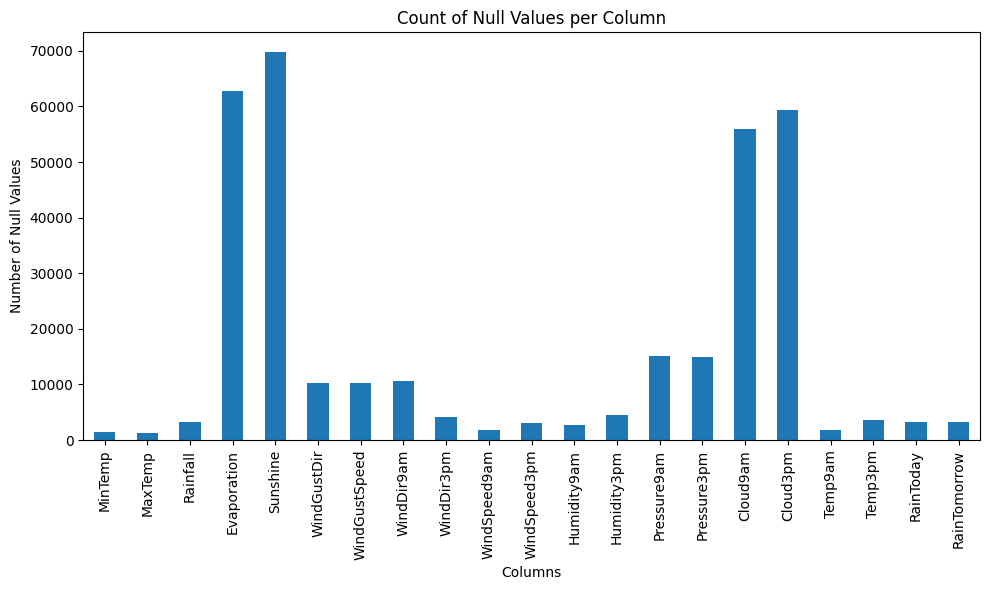

In [95]:
null_counts = df.isnull().sum()

# Filter out columns with zero null values
filtered_null_counts = null_counts[null_counts > 0]

plt.figure(figsize=(10, 6))
filtered_null_counts.plot(kind='bar')
plt.title('Count of Null Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\asifm\AppData\Local\Temp\ipykernel_38088\3026910906.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  nan_counts = df.isna().resample('Y').sum()


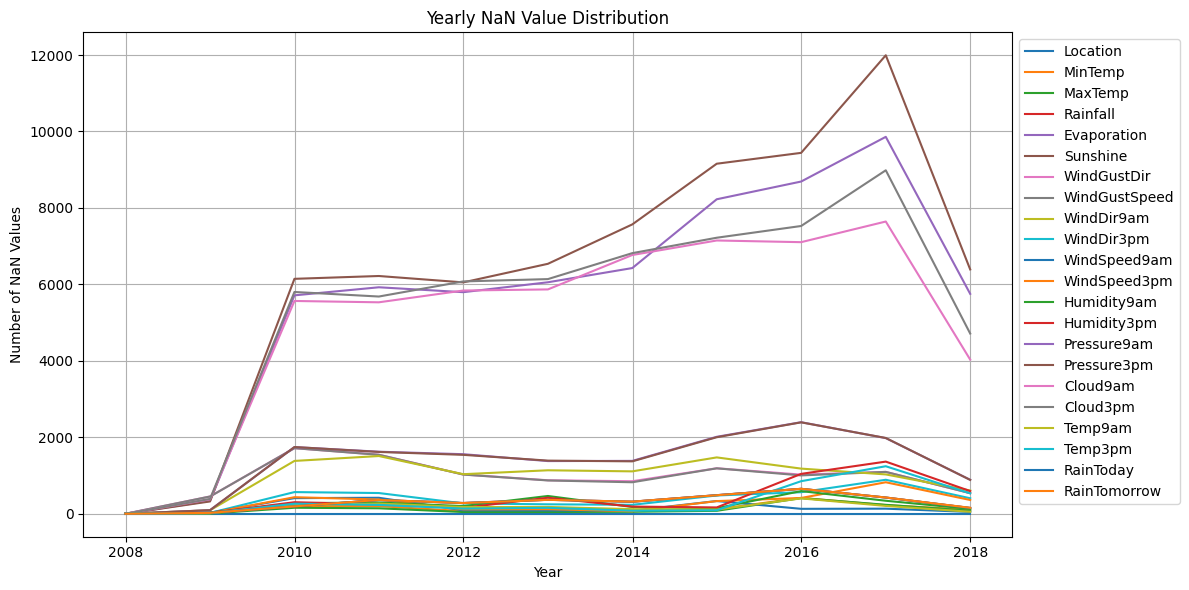

In [96]:
df.set_index('Date', inplace=True)

# Resample data by year and count NaN values
nan_counts = df.isna().resample('Y').sum()

# Plot the yearly NaN value distribution
plt.figure(figsize=(12, 6))
plt.plot(nan_counts)
plt.title('Yearly NaN Value Distribution')
plt.xlabel('Year')
plt.ylabel('Number of NaN Values')
plt.legend(nan_counts.columns, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Using interpolation to fill the Nan values for Evaporation, Sunshine, Cloud9am, and Cloud3pm 

In [97]:
df.loc[:, ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']] = df[['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']].interpolate(method='linear', limit_direction='forward')

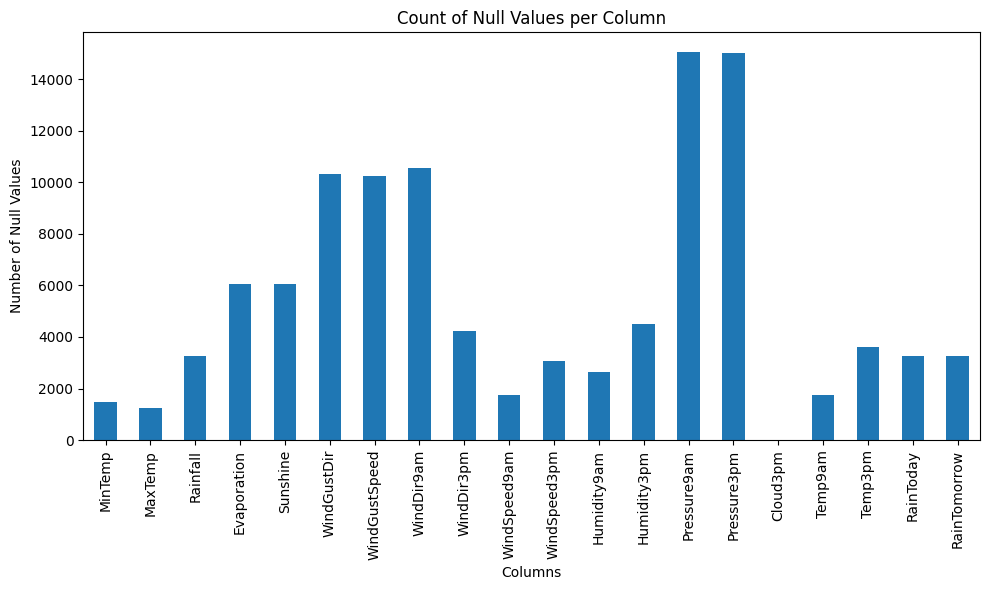

In [98]:
null_counts = df.isnull().sum()

# Filter out columns with zero null values
filtered_null_counts = null_counts[null_counts > 0]

plt.figure(figsize=(10, 6))
filtered_null_counts.plot(kind='bar')
plt.title('Count of Null Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Drop any N/A values in RainToday or RainTomorrow as they are categorical, very relavant to what we are trying to predict and that total number of missing is small in comparison to the dataset.

For missing values in Windgust directions, we will use the mode as that seems logical and shouldn't affect our final

In [99]:
# Check for missing values
df = df.dropna(subset=['RainToday', 'RainTomorrow'])

# Impute missing values. For numerical we will use means to replace and for categorical we will use mode.
for column in df.columns:
    if df[column].dtype == "float64":
        df[column] = df[column].fillna(df[column].mean())
    elif df[column].dtype == "object":
        df[column] = df[column].fillna(df[column].mode()[0])


In [100]:
null_counts = print(df.isnull().sum())

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [102]:
# Overview of unique values of categorical columns
categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

# Count unique values for each categorical column
for col in categorical_cols:
  n_unique = df[col].nunique()
  print(f"Column '{col}': {n_unique} unique values")


Column 'Location': 49 unique values
Column 'WindGustDir': 16 unique values
Column 'WindDir9am': 16 unique values
Column 'WindDir3pm': 16 unique values
Column 'RainToday': 2 unique values
Column 'RainTomorrow': 2 unique values


In [103]:
# Convert categorical variables to numerical
categorical_columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm','RainToday', 'RainTomorrow']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=int)

In [108]:
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,13.4,22.9,0.6,6.474108,7.663953,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,1,0,0,1
2008-12-02,7.4,25.1,0.0,6.474108,7.663953,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,1,0,0
2008-12-03,12.9,25.7,0.0,6.474108,7.663953,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,1,0,0
2008-12-04,9.2,28.0,0.0,6.474108,7.663953,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,0,0
2008-12-05,17.5,32.3,1.0,6.474108,7.663953,41.0,7.0,20.0,82.0,33.0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
# Define features and target
data = df.drop(['RainTomorrow_Yes'], axis=1)
y = df['RainTomorrow_Yes']

#standardizign the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Create a new dataframe with the scaled data, keeping the same column names
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# combining features and targets
scaled_df = pd.concat([scaled_data, y], axis=1)

scaled_df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow_Yes
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,0.190073,-0.047155,-0.206727,3.274925e-16,0.0,0.306850,0.678824,0.615792,0.114615,-1.433272,...,-0.268817,-0.335556,-0.261916,-0.244557,-0.262937,-0.273676,3.929300,-0.264892,-0.536378,1
2008-12-02,-0.748424,0.262411,-0.277606,3.274925e-16,0.0,0.306850,-1.128510,0.386398,-1.309391,-1.287264,...,-0.268817,-0.335556,-0.261916,-0.244557,-0.262937,-0.273676,-0.254498,3.775122,-0.536378,0
2008-12-03,0.111865,0.346838,-0.277606,3.274925e-16,0.0,0.459153,0.565865,0.845186,-1.625837,-1.043919,...,-0.268817,-0.335556,-0.261916,-0.244557,-0.262937,-0.273676,-0.254498,3.775122,-0.536378,0
2008-12-04,-0.466875,0.670476,-0.277606,3.274925e-16,0.0,-1.216176,-0.337801,-1.104663,-1.256650,-1.725287,...,-0.268817,-0.335556,-0.261916,-0.244557,-0.262937,-0.273676,-0.254498,-0.264892,-0.536378,0
2008-12-05,0.831379,1.275538,-0.159474,3.274925e-16,0.0,0.078396,-0.789635,0.157004,0.694765,-0.897911,...,-0.268817,-0.335556,-0.261916,-0.244557,-0.262937,-0.273676,-0.254498,-0.264892,-0.536378,0


Moving on to modeling phase

In [133]:
features = df.drop(columns=['RainTomorrow_Yes'])
target = df['RainTomorrow_Yes']

In [163]:
target.head()

Date
2008-12-01    1
2008-12-02    0
2008-12-03    0
2008-12-04    0
2008-12-05    0
Name: RainTomorrow_Yes, dtype: int32

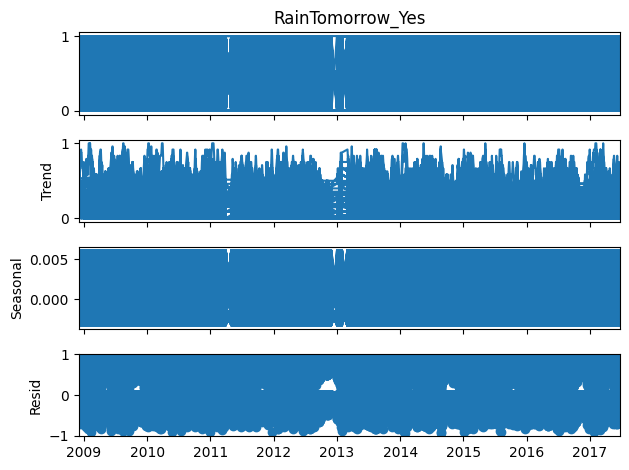

In [169]:
# Seasonal decomposition of the target variable
result = seasonal_decompose(target, model='additive', period=12)

# Plot the decomposition
result.plot()
plt.show()

In [178]:
# Perform Augmented Dickey-Fuller test to check for stationarity
adf_test = adfuller(target)

print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
#for key, value in adf_test[4].items():
#    print('Critical Values:')
#    print(f'   {key}, {value}')

if adf_test[1] <= 0.05:
    print("The series is stationary")
else:
    print("The series is not stationary")


ADF Statistic: -28.501553133270534
p-value: 0.0
The series is stationary


In [134]:
# Split the data into training and test sets (80% training, 20% test)
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.2, random_state=42)

In [135]:
# Define the SARIMAX model
order = (1, 0, 0)  # (p, d, q)
seasonal_order = (0, 1, 1, 12)  # (P, D, Q, s)

In [136]:
# Fit the SARIMAX model on the training data
model = sm.tsa.statespace.SARIMAX(train_target, 
                                  exog=train_features, 
                                  order=order, 
                                  seasonal_order=seasonal_order)

c:\Users\asifm\Office Work\23.1 CLL Classification Project\2. Notebooks\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\asifm\Office Work\23.1 CLL Classification Project\2. Notebooks\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\asifm\Office Work\23.1 CLL Classification Project\2. Notebooks\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\asifm\Office Work\23.1 CLL Classification Project\2. Notebooks\myenv\lib\site-packages\statsmode

In [137]:
sarimax_result = model.fit()

c:\Users\asifm\Office Work\23.1 CLL Classification Project\2. Notebooks\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [140]:
sarimax_summary = sarimax_result.summary()

In [141]:
print(sarimax_summary)

                                      SARIMAX Results                                       
Dep. Variable:                     RainTomorrow_Yes   No. Observations:               112629
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood              -39750.439
Date:                              Thu, 18 Jul 2024   AIC                          79726.877
Time:                                      09:02:58   BIC                          80815.265
Sample:                                           0   HQIC                         80055.422
                                           - 112629                                         
Covariance Type:                                opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
MinTemp                       0.0014      0.001      2.543      0.01

In [151]:
# Train the SARIMA model
#model = SARIMAX(train['RainTomorrow_Yes'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
#sarima_model = model.fit()
#print(sarima_model.summary())

In [142]:
train_predictions = sarimax_result.predict(start=0, end=len(train_target)-1, exog=train_features)

In [143]:
train_predictions.describe()

count    112629.000000
mean          0.220559
std           0.265843
min          -8.664042
25%           0.042577
50%           0.182689
75%           0.362914
max           2.200948
Name: predicted_mean, dtype: float64

In [148]:
# Make predictions on the test data
test_predictions = sarimax_result.predict(start=len(train_target), 
                                          end=len(train_target) + len(test_target) - 1, 
                                          exog=test_features)

c:\Users\asifm\Office Work\23.1 CLL Classification Project\2. Notebooks\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\asifm\Office Work\23.1 CLL Classification Project\2. Notebooks\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [195]:
# Convert predictions to binary classifications
test_predictions_binary = np.where(test_predictions > 0.5, 1, 0)


In [196]:
accuracy = accuracy_score(test_target, test_predictions_binary)
print(f'Accuracy: {accuracy}')

Accuracy: 0.842034235386036


In [197]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate accuracy metrics
mse = mean_squared_error(test_target, test_predictions)
mae = mean_absolute_error(test_target, test_predictions)
r2 = r2_score(test_target, test_predictions)

# Print the accuracy metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 0.11907870590290619
Mean Absolute Error (MAE): 0.2646224537658177
R^2 Score: 0.31141133759373796


In [198]:
# Print the classification report
print('\nClassification Report:')
print(classification_report(test_target, test_predictions_binary))



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     21896
           1       0.72      0.47      0.57      6262

    accuracy                           0.84     28158
   macro avg       0.79      0.71      0.74     28158
weighted avg       0.83      0.84      0.83     28158



NEXT TASKS:

1. PCA / Dimensionality reduction

2. Model tuning (p, d, q) by using ACF / PACF, and defining lags
    p ----> AR model lags (1)
    d ----> differencing (0)
    q ----> MA lags (0)
3. Seasnonality k cofirmation

4. Removing non-significant features ( p value > 5% is sarimax summary)?

5. Make sure that dataset in training set is 'Balanced'

6. Fill all null values with suitable data instead of removing them 
